<a href="https://colab.research.google.com/github/madhurlak0810/Skin-Ham-10000-ml/blob/main/SkinCancerClassifacation_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'skin-cancer-mnist-ham10000:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F54339%2F104884%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240505%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240505T065331Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D30e1c543652d5923dde9ef36a8e36205037634db5aa14d05949e62baec691b50e68f1f989c2d3641372c069f7d16677ac24c01cf23b1ba8898c39a0160703eefd6709172e42d30bc1d18ded4fa6893b0fb7820ed984d8ffa28efd9c7d95704fa1f8bafaf9ecf34536b658a7269a516d40ea5558040df4372d8c06c384fd887a6f80a398add9d5c09a3b12bd27945c830833824da6626ec2e9a03467e2d5374adc468b15799bfacde4d30447ca48374bb9e41bcb9f7ff7dcdab21f721e233c2e0e350a00adc61e065a133dfbb0527ed4b0e1996926f3cdb363bd832bcc208431f30a007d3bc874ae1b1b18fdc15351f6e69a07aa7c2ad89cdd18dd4c69545d3de'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 5582914511 bytes downloaded
Downloaded and uncompressed: skin-cancer-mnist-ham10000
Data source import complete.


In [2]:
!pip install imutils
!pip install efficientnet

import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


import matplotlib as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
import warnings
warnings.filterwarnings('ignore')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.1 MB/s eta 0:00:00


In [3]:
skinDf=pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
skin_df=skinDf
size=32
skinDf


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [4]:
from sklearn.preprocessing import LabelEncoder
labelEncoder = LabelEncoder()
labelEncoder.fit(skinDf['dx'])
skinDf['label']=labelEncoder.transform(skinDf['dx'])



In [5]:
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [6]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))

def summary_table(df):
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values
    summary['Uniques'] = df.nunique().values
    return summary

def countplot(df, x, x_axis_title,y_axys_title, plot_title):
    plt.figure(figsize=(20,8))
    sns.set(style="ticks", font_scale = 1)
    ax = sns.countplot(data = df,x=x,order = df[x].value_counts().index,palette="Blues_d")
    sns.despine(top=True, right=True, left=True, bottom=False)
    plt.xticks(rotation=0,fontsize = 12)
    ax.set_xlabel(x_axis_title,fontsize = 14,weight = 'bold')
    ax.set_ylabel(y_axys_title,fontsize = 14,weight = 'bold')
    plt.title(plot_title, fontsize = 16,weight = 'bold')

In [7]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [8]:
basic_EDA(skin_df)

Number of Samples: 10015,
Number of Features: 10,
Duplicated Entries: 0,
Null Entries: 57,
Number of Rows with Null Entries: 57 0.6%


In [9]:
summary_table(skin_df)

,Name,dtypes,Missing,Uniques
0,lesion_id,object,0,7470
1,image_id,object,0,10015
2,dx,object,0,7
3,dx_type,object,0,4
4,age,float64,57,18
5,sex,object,0,3
6,localization,object,0,15
7,label,int64,0,7
8,cell_type,object,0,7
9,cell_type_idx,int8,0,7


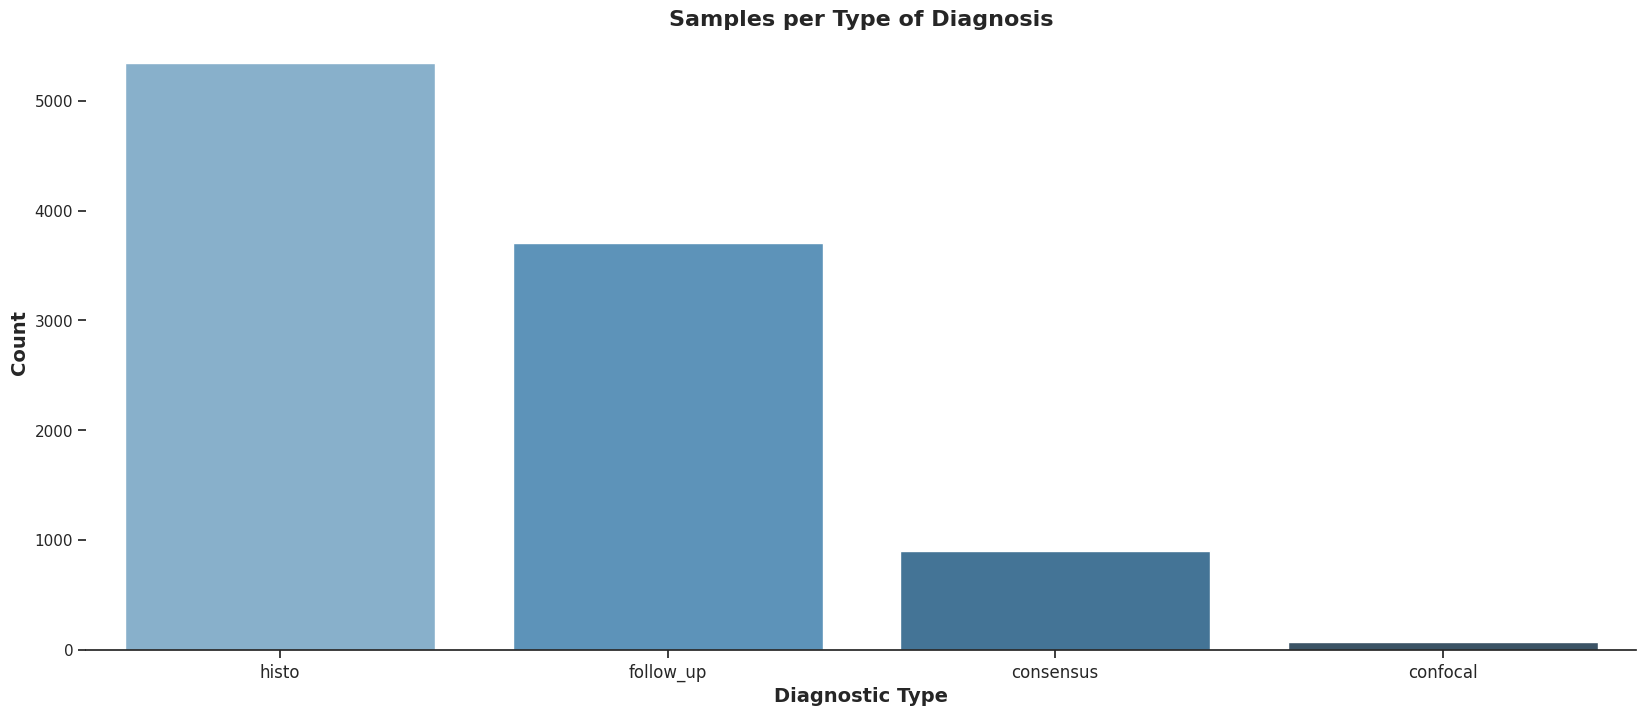

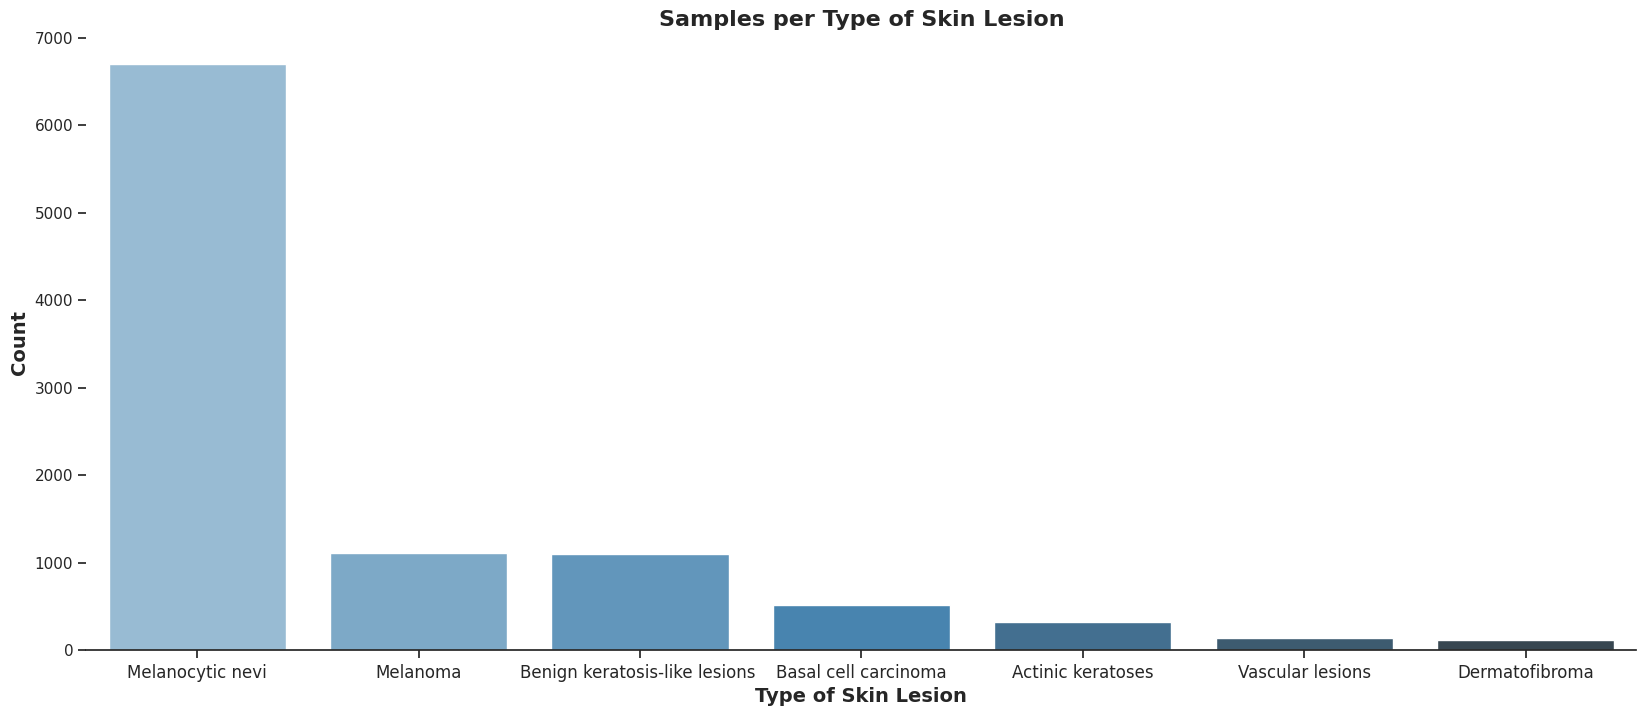

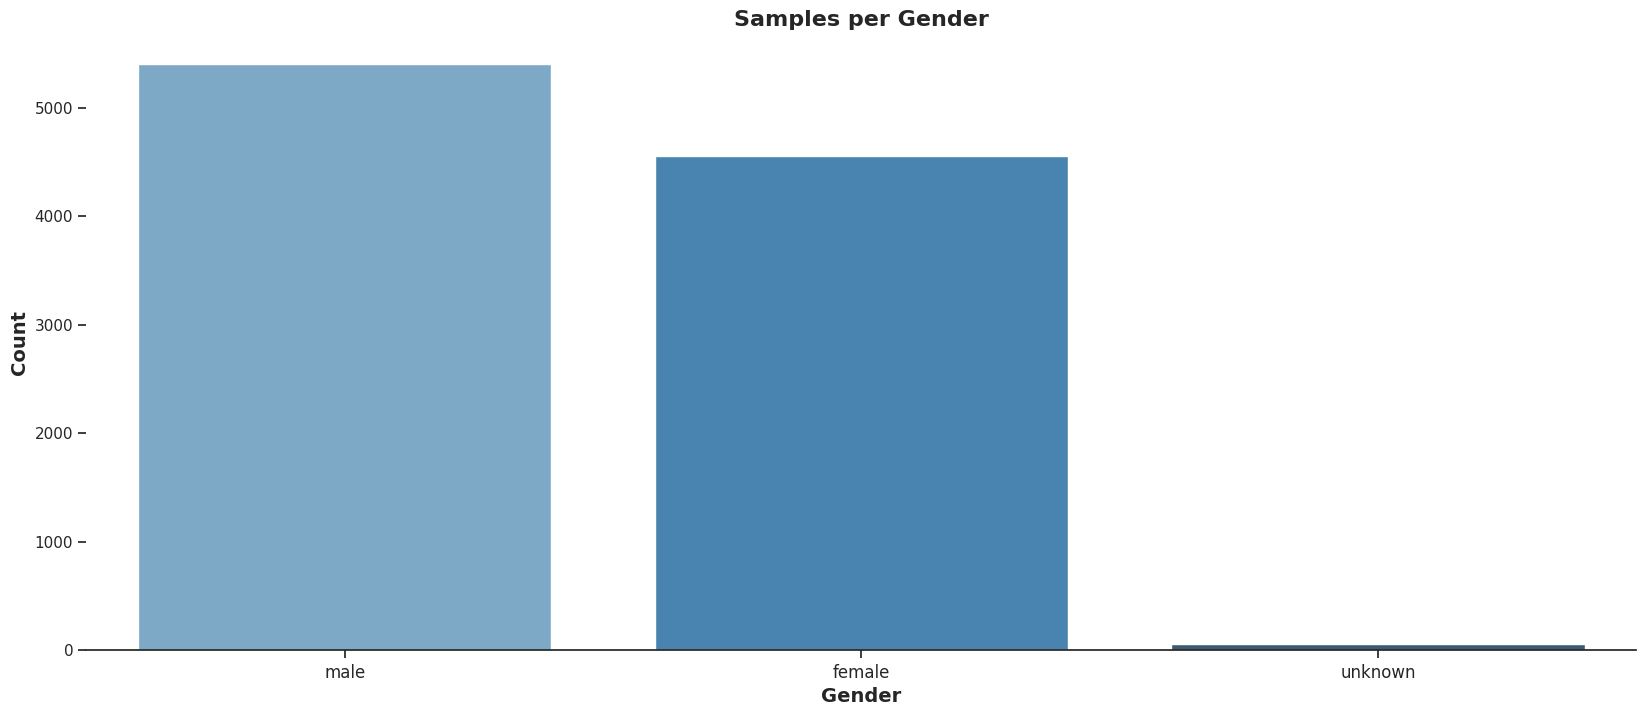

In [10]:
countplot(skin_df,'dx_type', 'Diagnostic Type', 'Count', 'Samples per Type of Diagnosis')
countplot(skin_df,'cell_type', 'Type of Skin Lesion', 'Count', 'Samples per Type of Skin Lesion')
countplot(skin_df,'sex', 'Gender', 'Count', 'Samples per Gender')

In [14]:

def heatmap(df, index,columns,values,vmax,sort_by,Title):
    df_wide = df.pivot(index=index, columns=columns, values=values)
    df_wide = df_wide.reindex(index=sort_by)
    plt.figure(figsize=(12,8))
    ax = sns.heatmap(df_wide, annot=True, fmt='.0f', yticklabels='auto', cmap=sns.color_palette("YlGnBu", as_cmap=True), center=.2,vmin = 0, vmax = vmax,linewidths=.5)
    ax.xaxis.tick_top() # x axis on top
    ax.xaxis.set_label_position('top')
    ax.set_xlabel(columns,fontsize = 14,weight = 'bold')
    ax.set_ylabel(index,fontsize = 14,weight = 'bold')
    ax.set_title(Title,fontsize = 16,weight = 'bold',pad=20)
    plt.show()

In [20]:
def ageandlocal(dflocal,type):
  print(type)
  dflocal=dflocal.loc[:,['age','sex','localization','cell_type']]
  dflocal= dflocal[dflocal['cell_type'] == type]
  countplot(dflocal,'sex', 'Gender', 'Count', type +' - Malignant Cancer per Gender')
  plt.figure(figsize=(20,8))
  sns.set(style="ticks", font_scale = 1)
  ax = sns.countplot(data = dflocal,x='age',palette="Blues_d", hue = 'sex')
  sns.despine(top=True, right=True, left=True, bottom=False)
  plt.xticks(rotation=0,fontsize = 12)
  ax.set_xlabel('Age',fontsize = 14,weight = 'bold')
  ax.set_ylabel('Count',fontsize = 14,weight = 'bold')
  plt.title('Age Distribution -' +type, fontsize = 16,weight = 'bold');

  skin_local = dflocal.groupby(['localization']).size().sort_values(ascending=False, inplace=False).reset_index()
  skin_local.columns = ['localization', 'count']
  sort_by = skin_local['localization']

  skin_heat = dflocal.groupby(['age','localization']).size().reset_index()
  skin_heat.columns = ['age', 'localization', 'count']
  skin_heat.sort_values('count', ascending=False, inplace=True)
  heatmap(skin_heat,'localization', 'age','count', 20,sort_by,'Age and Localization of'+type)

Melanocytic nevi


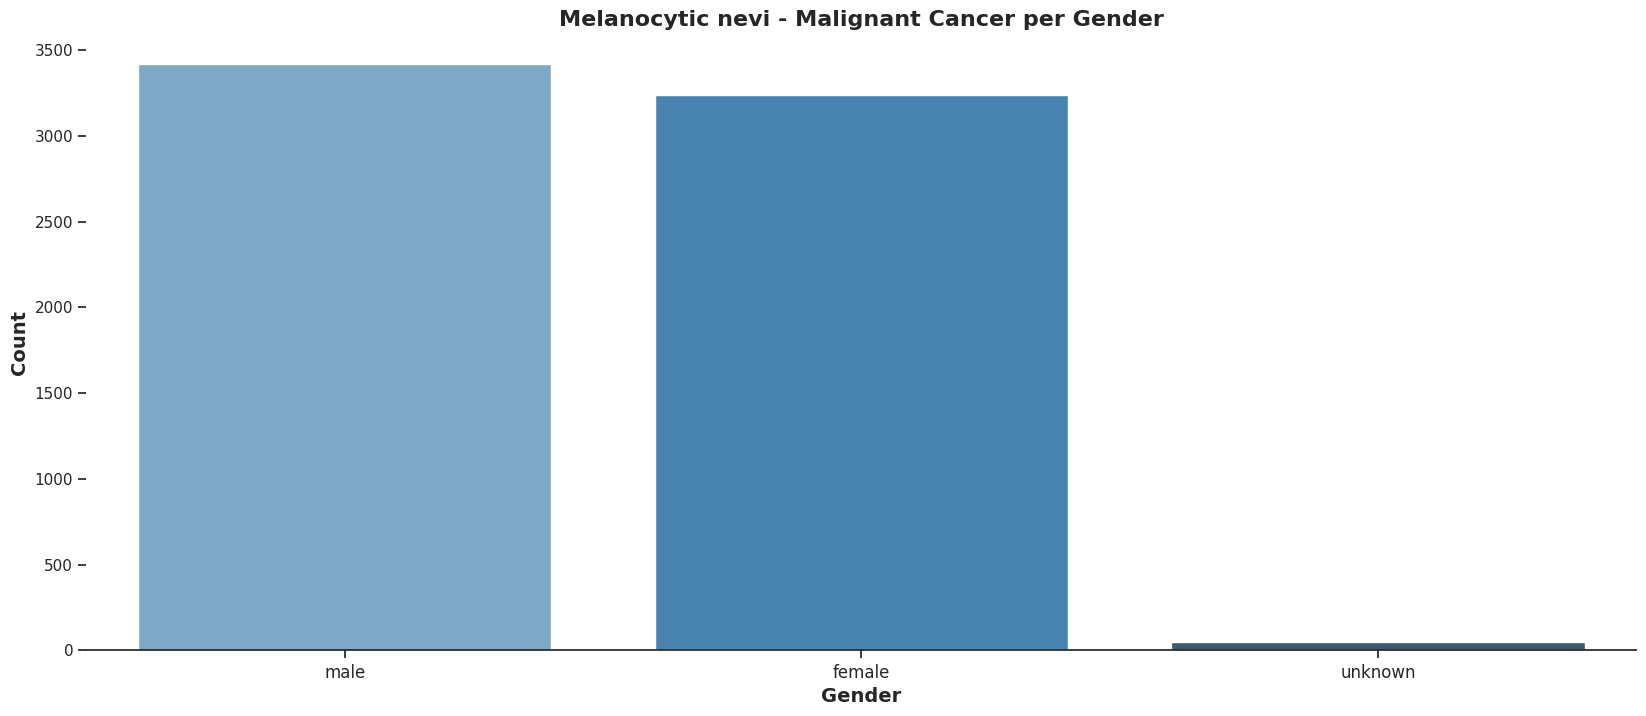

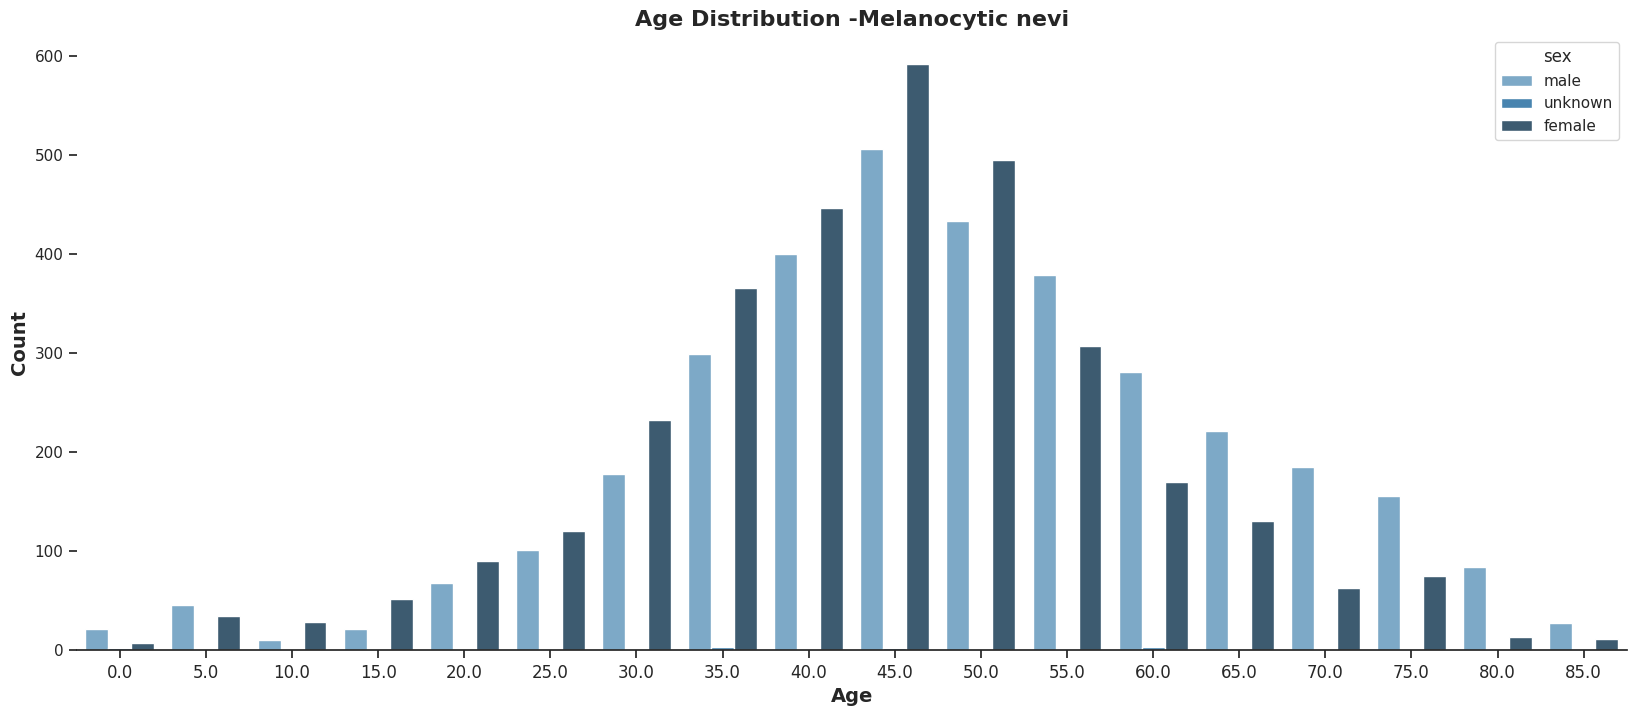

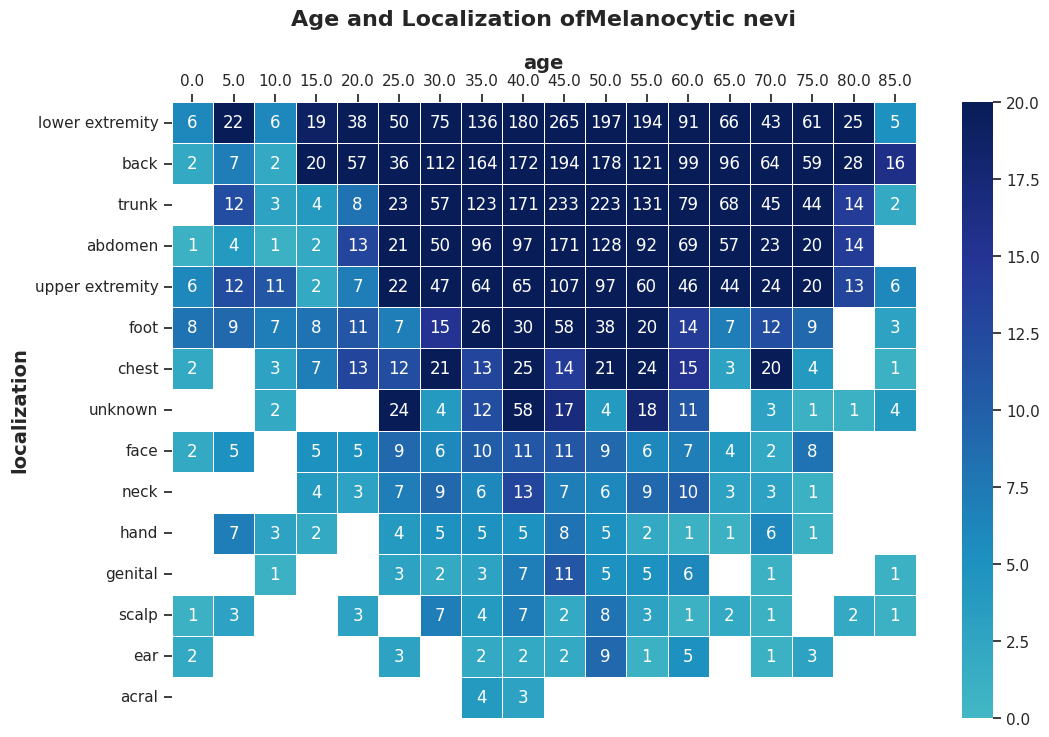

Melanoma


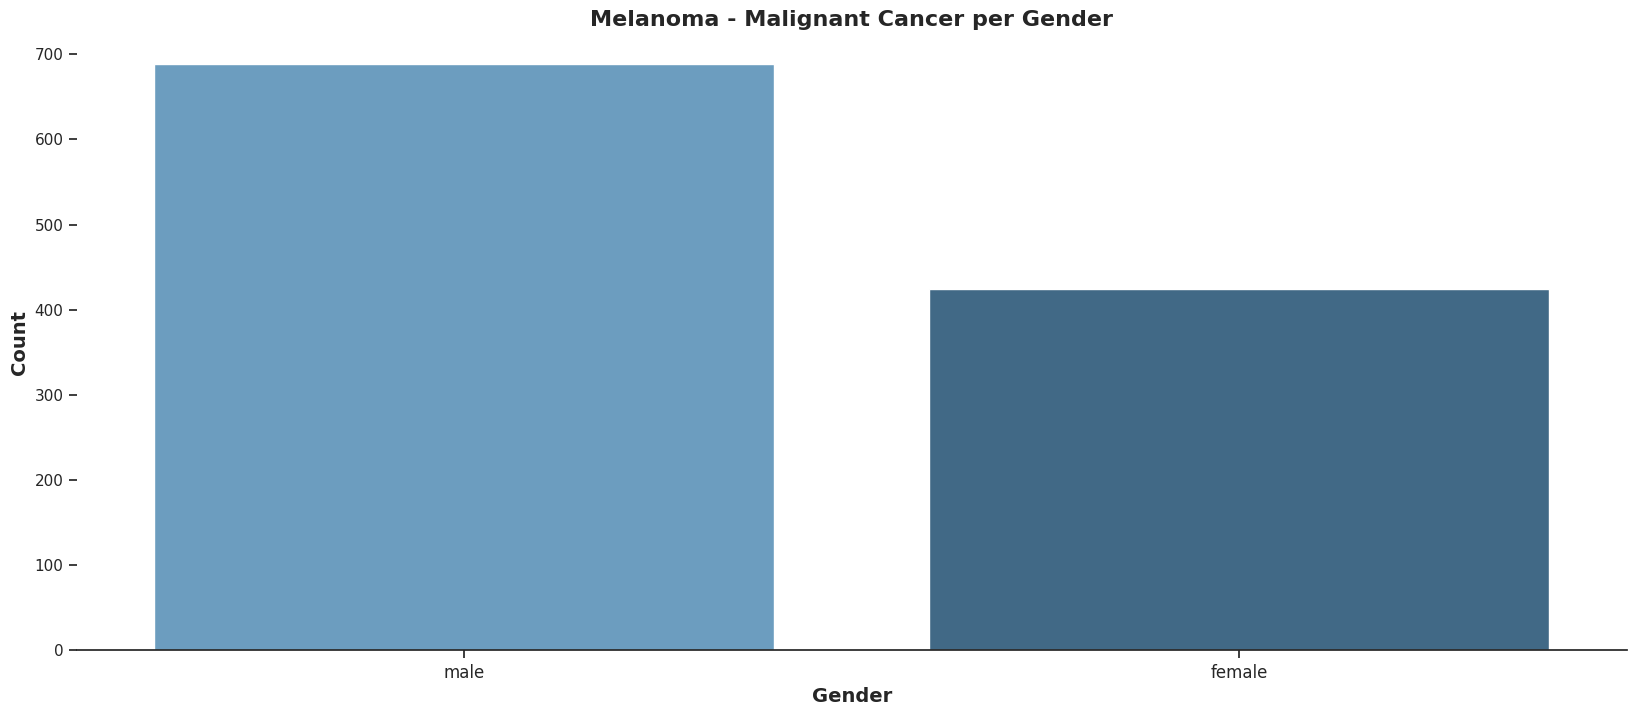

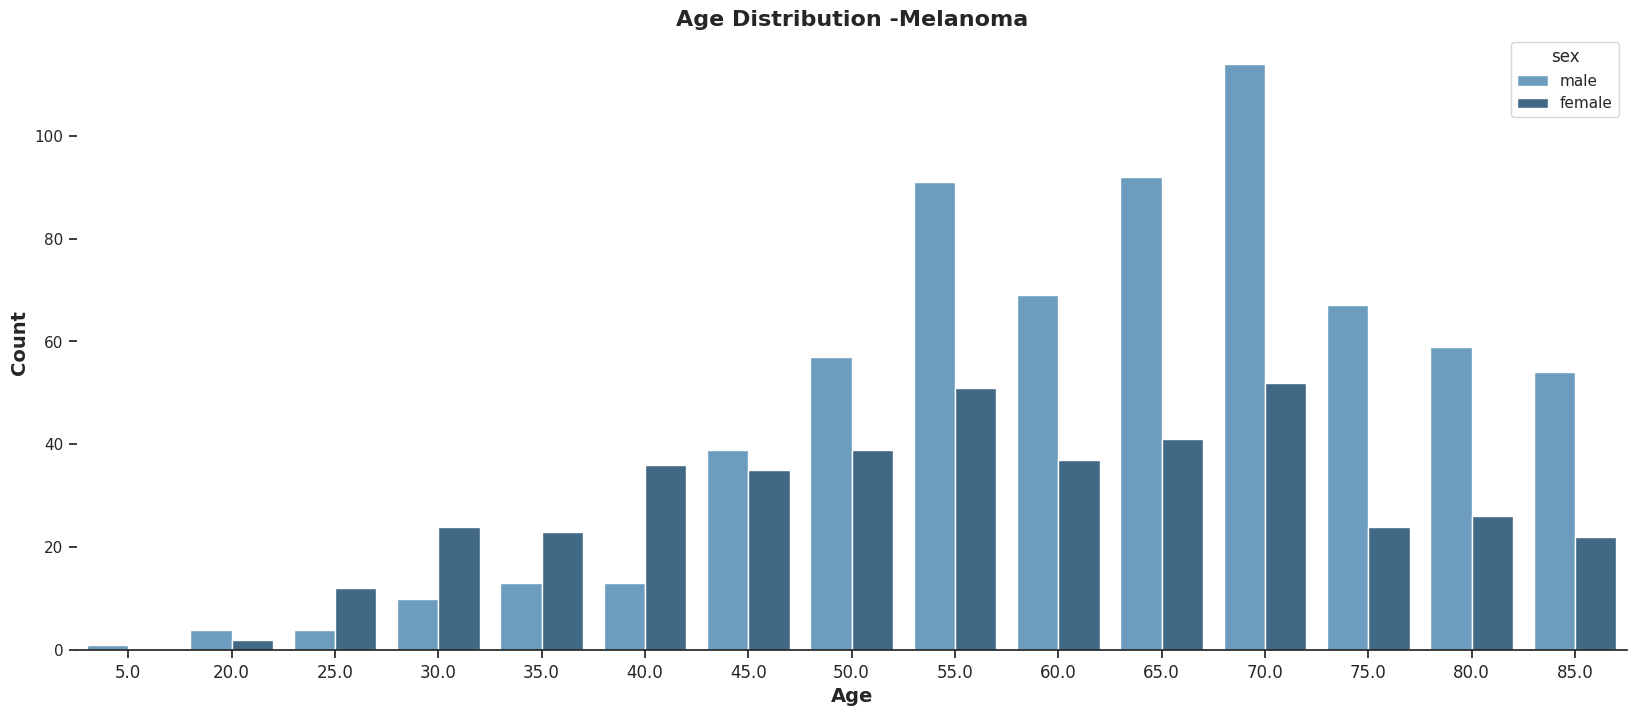

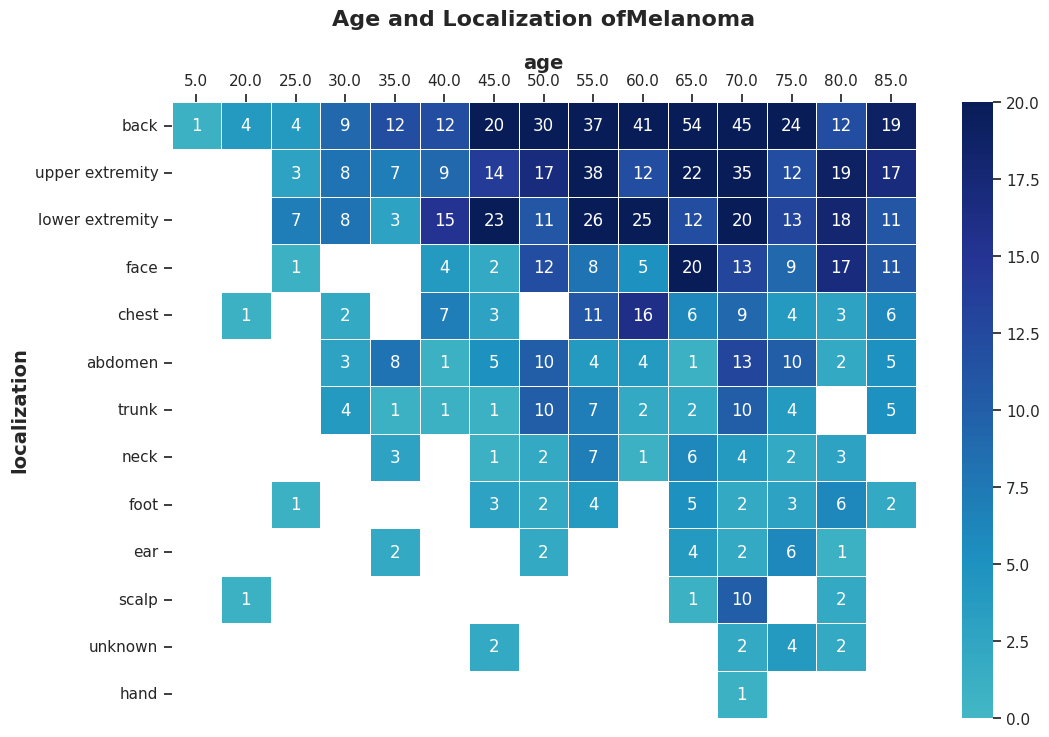

Benign keratosis-like lesions 


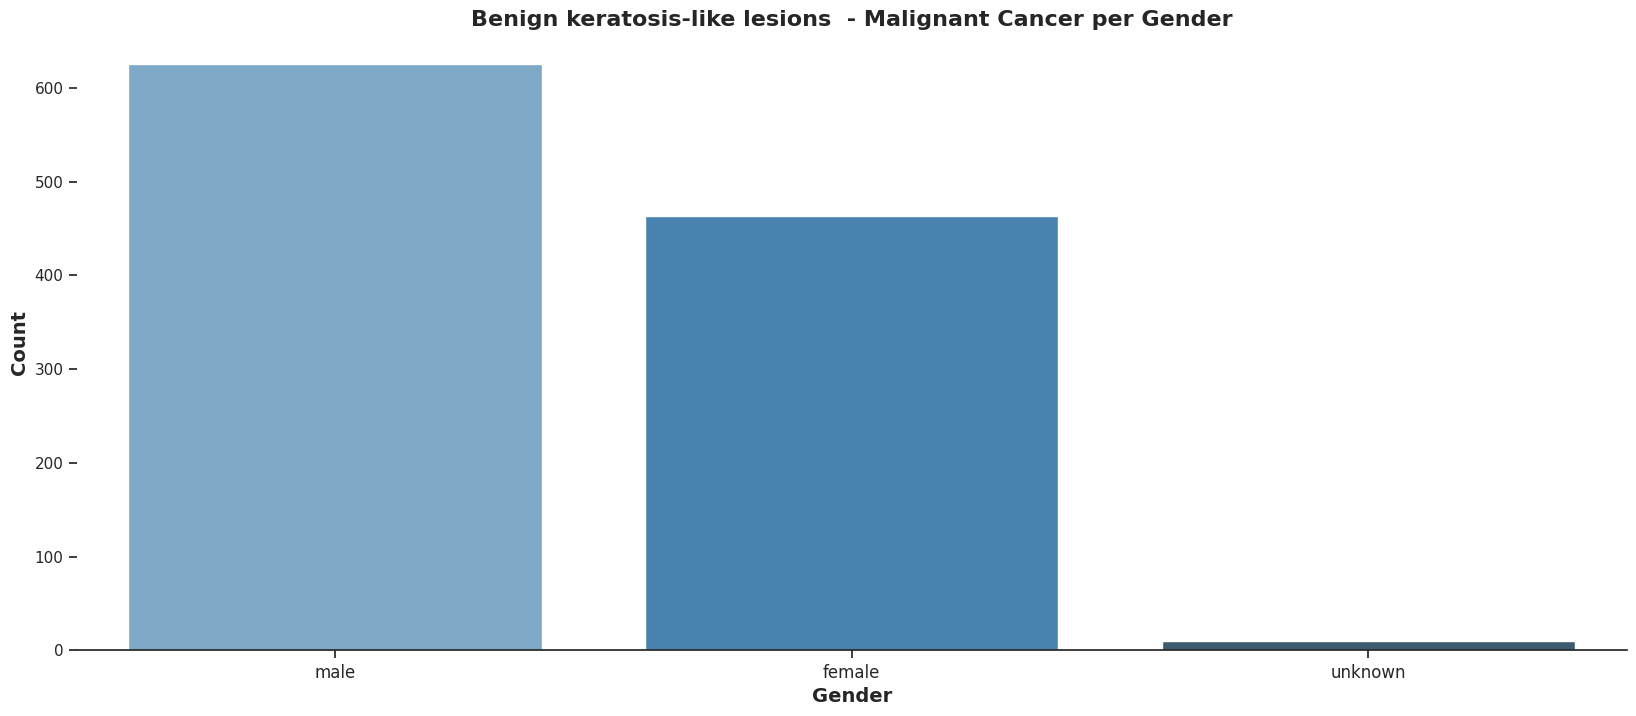

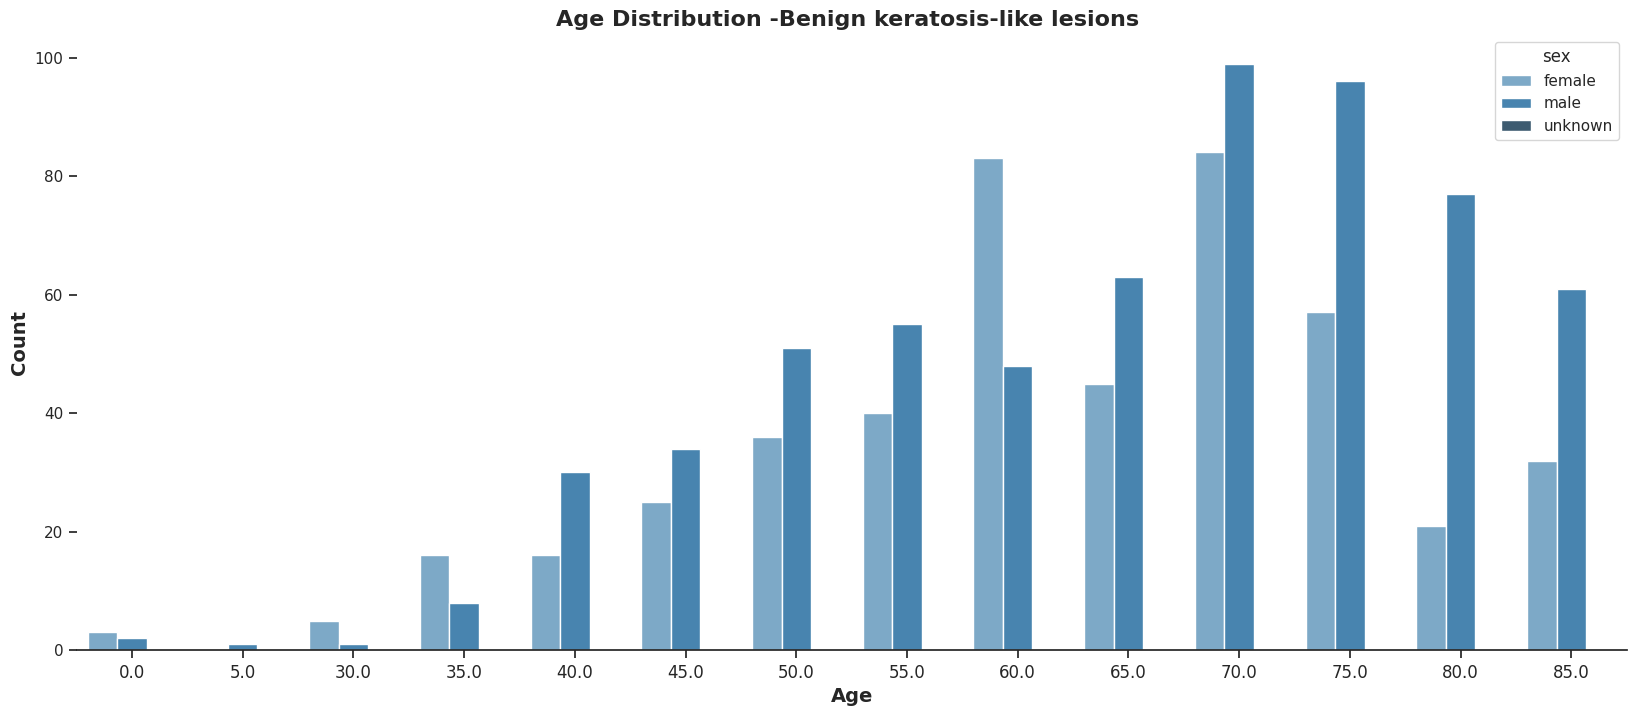

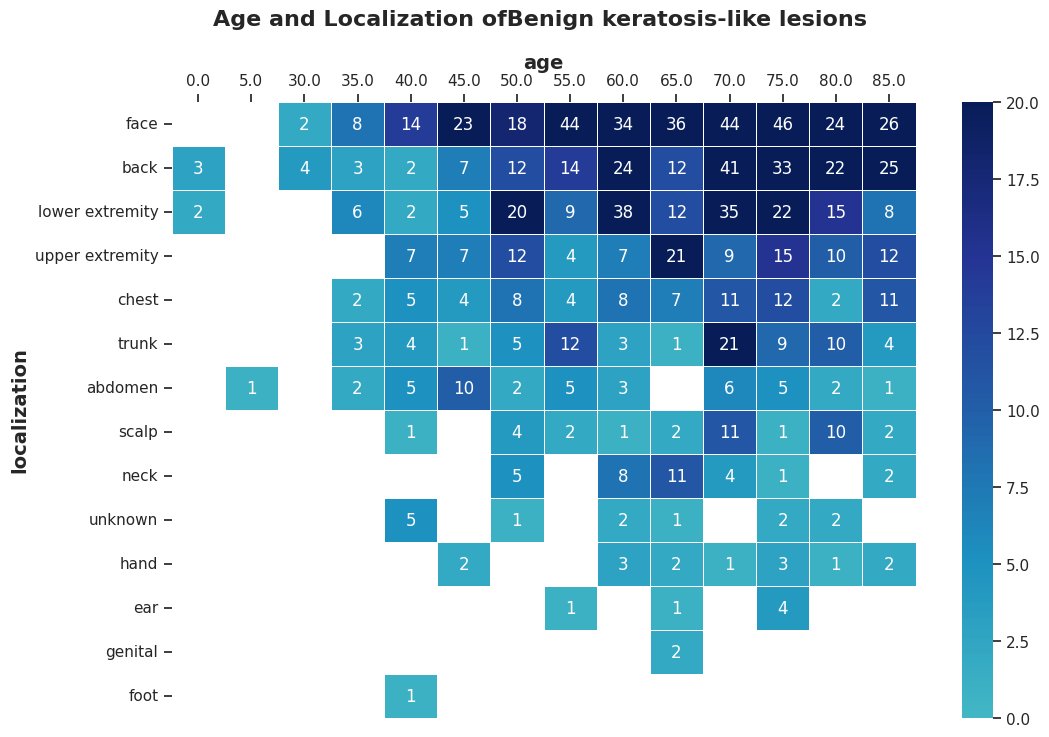

Basal cell carcinoma


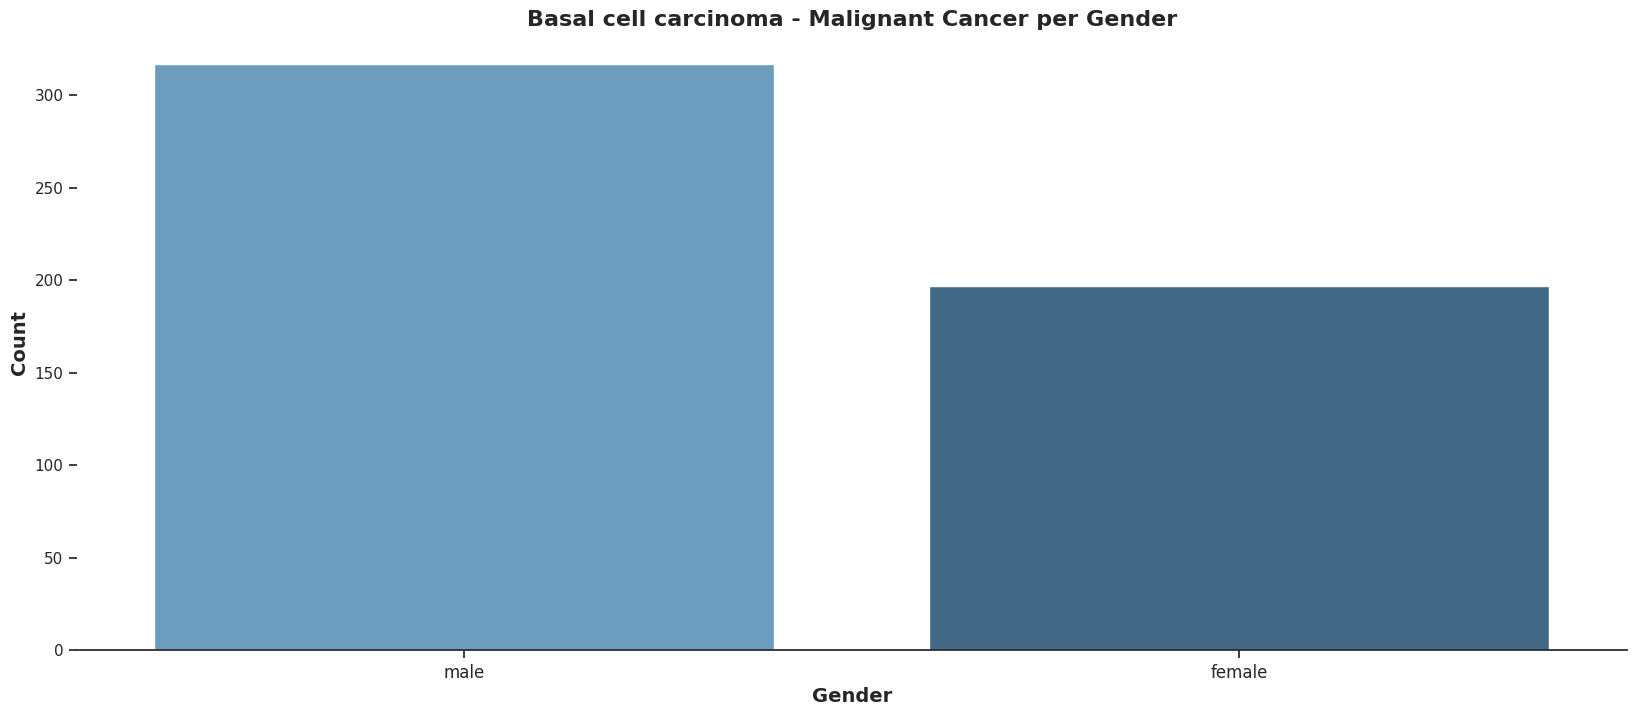

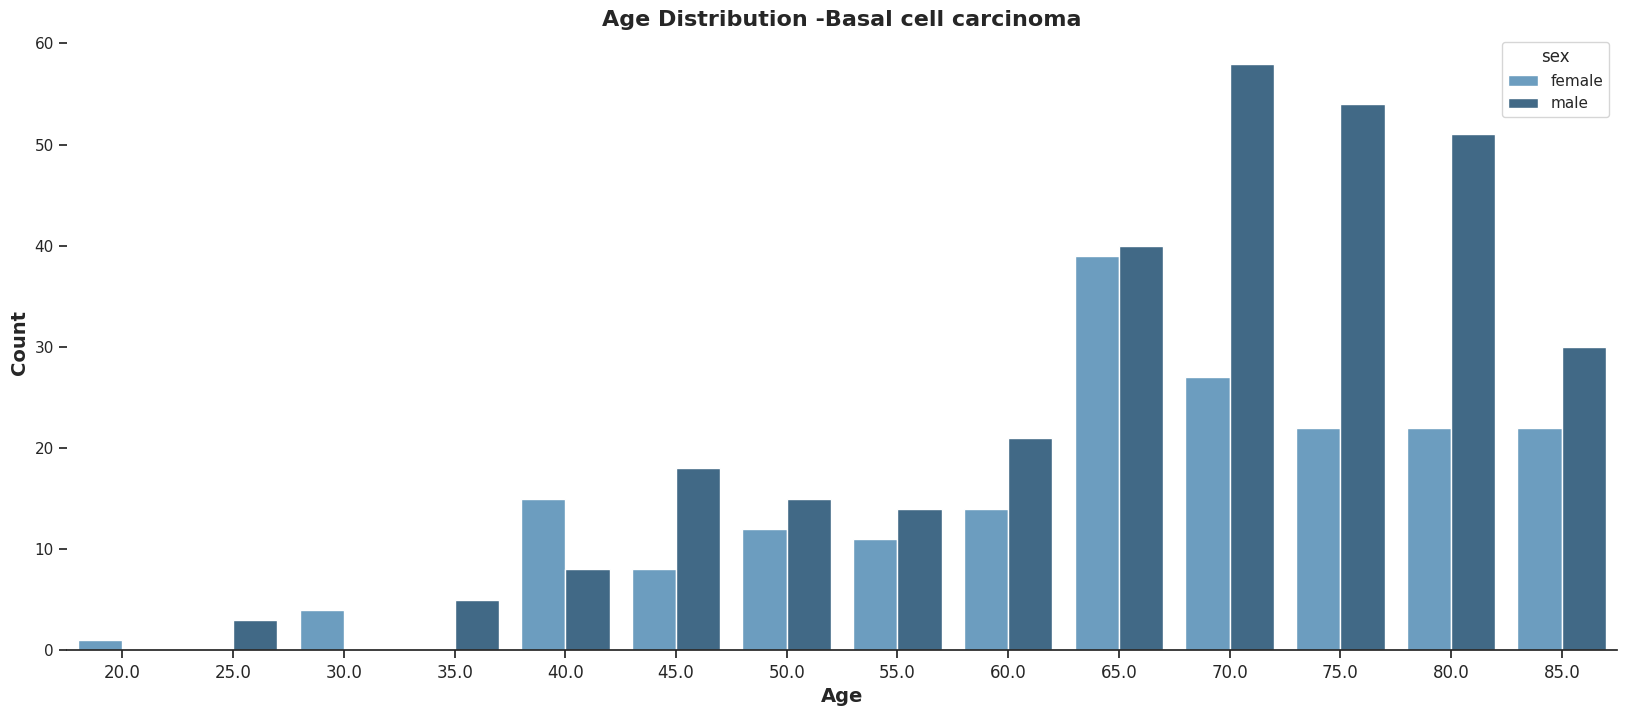

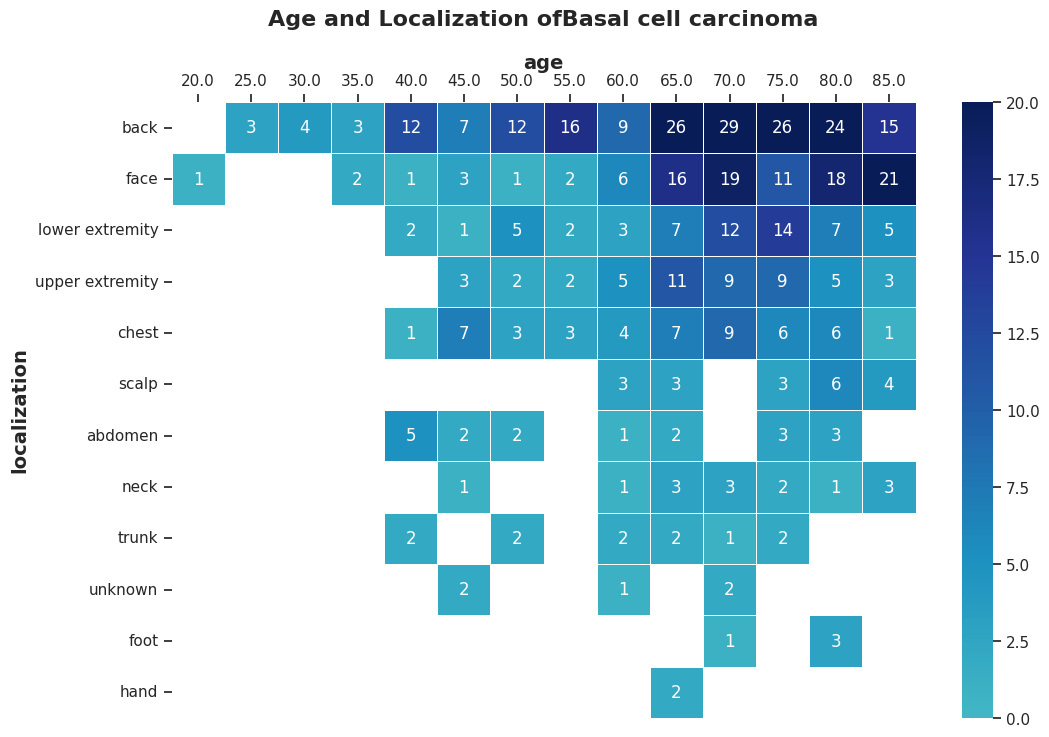

Actinic keratoses


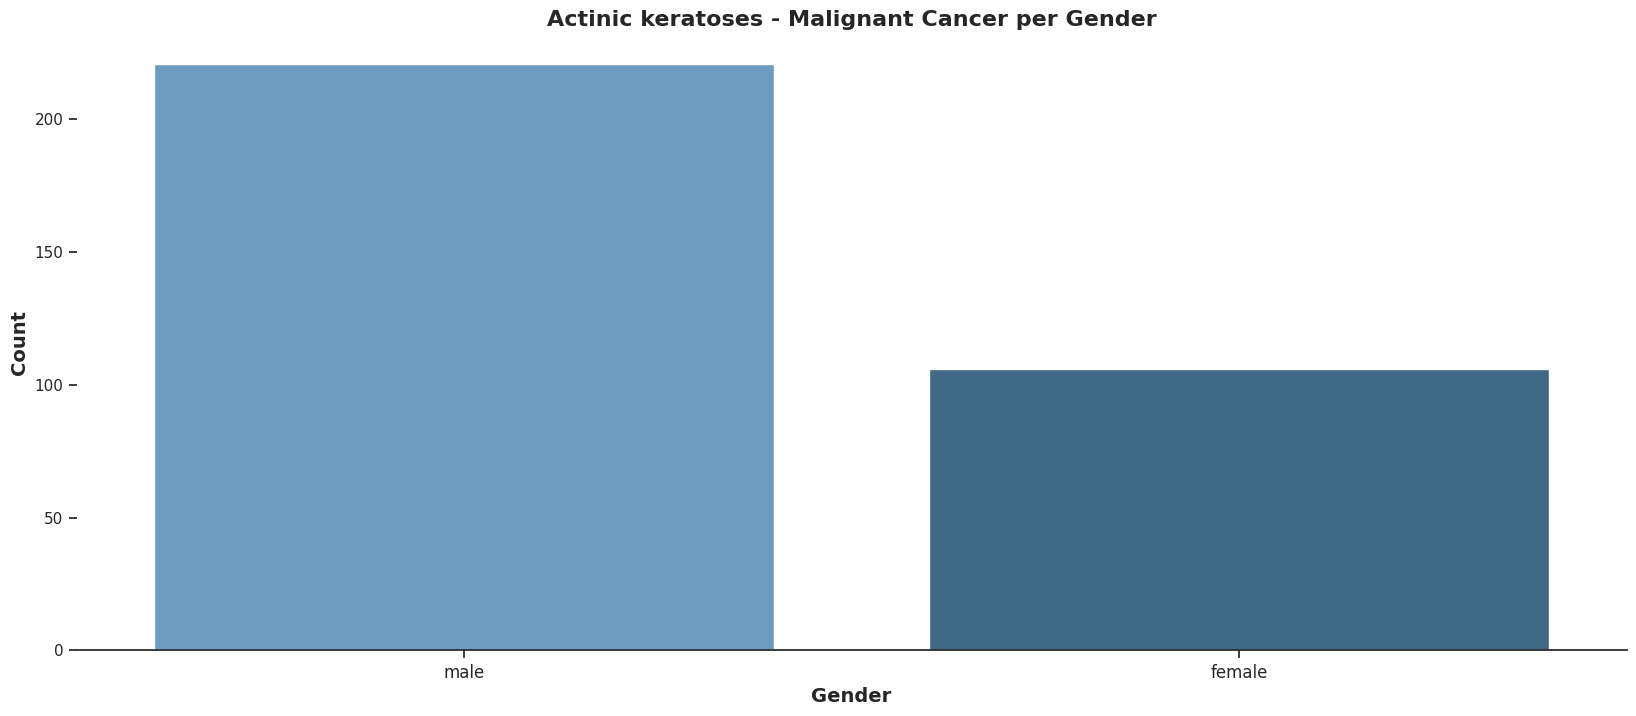

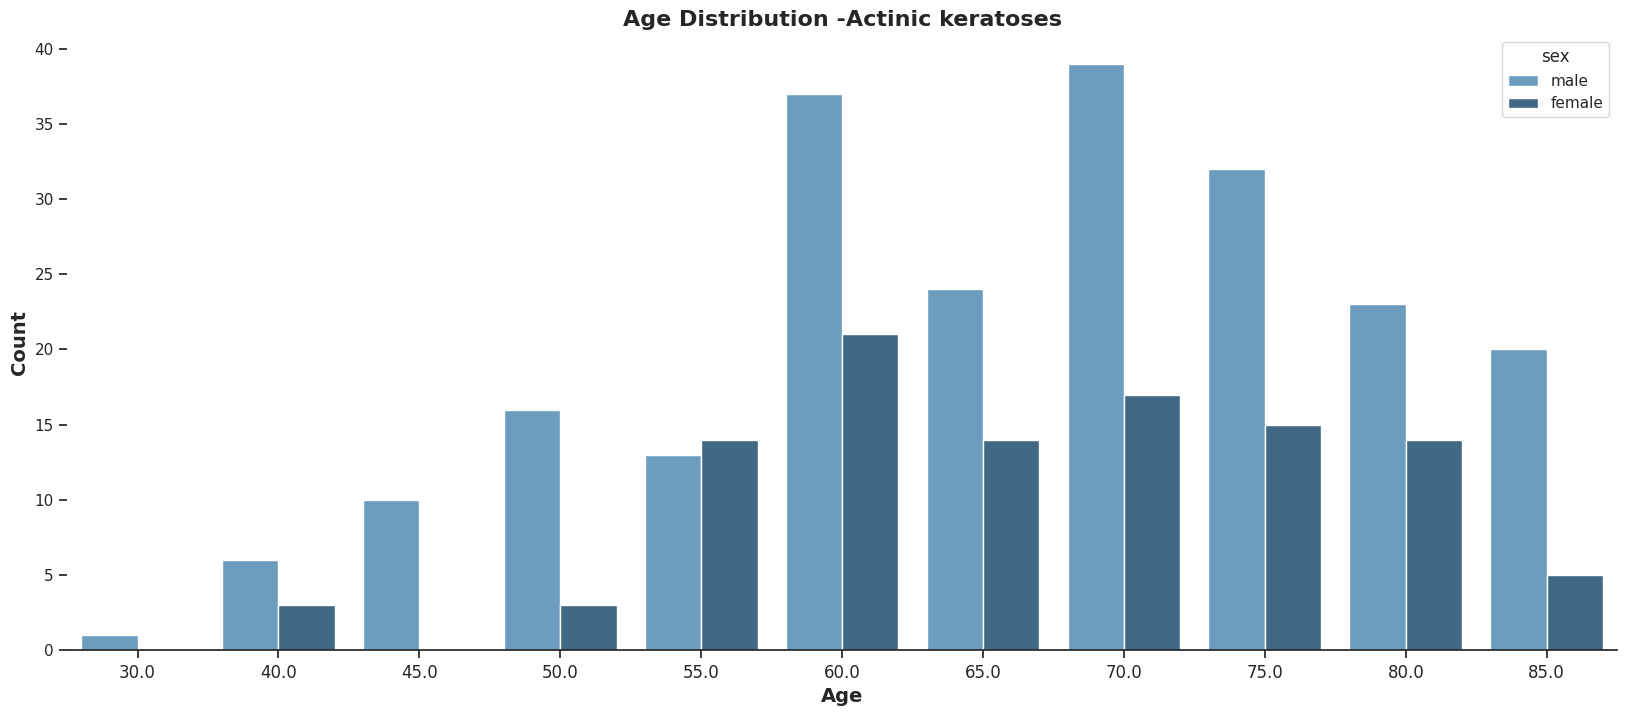

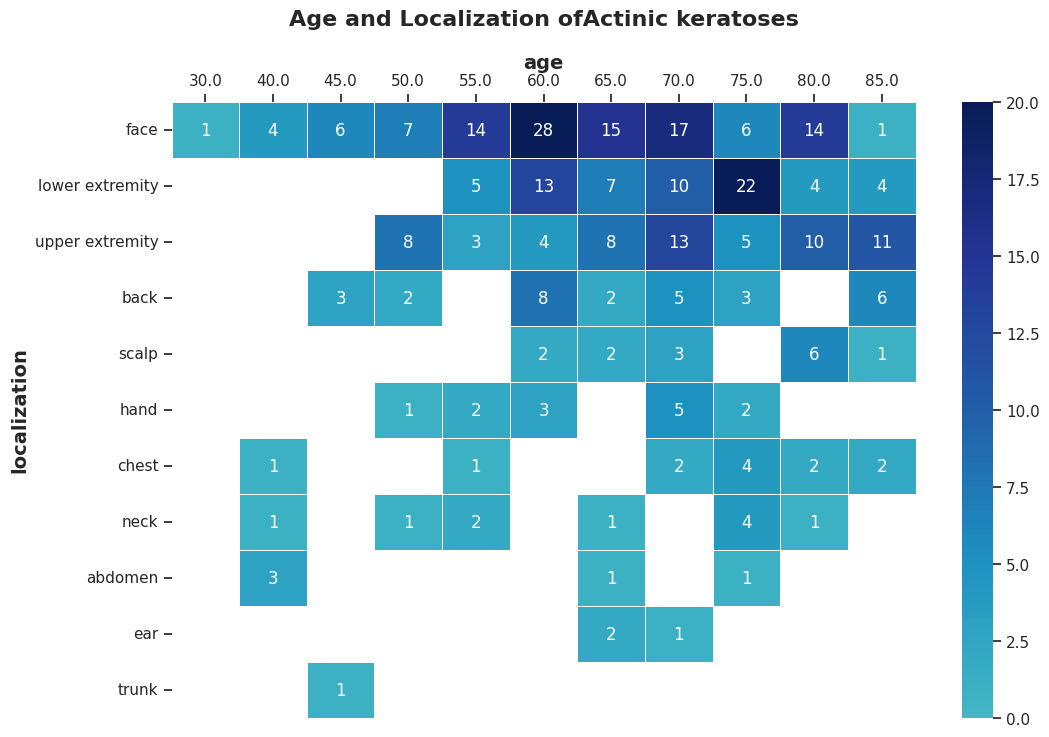

Vascular lesions


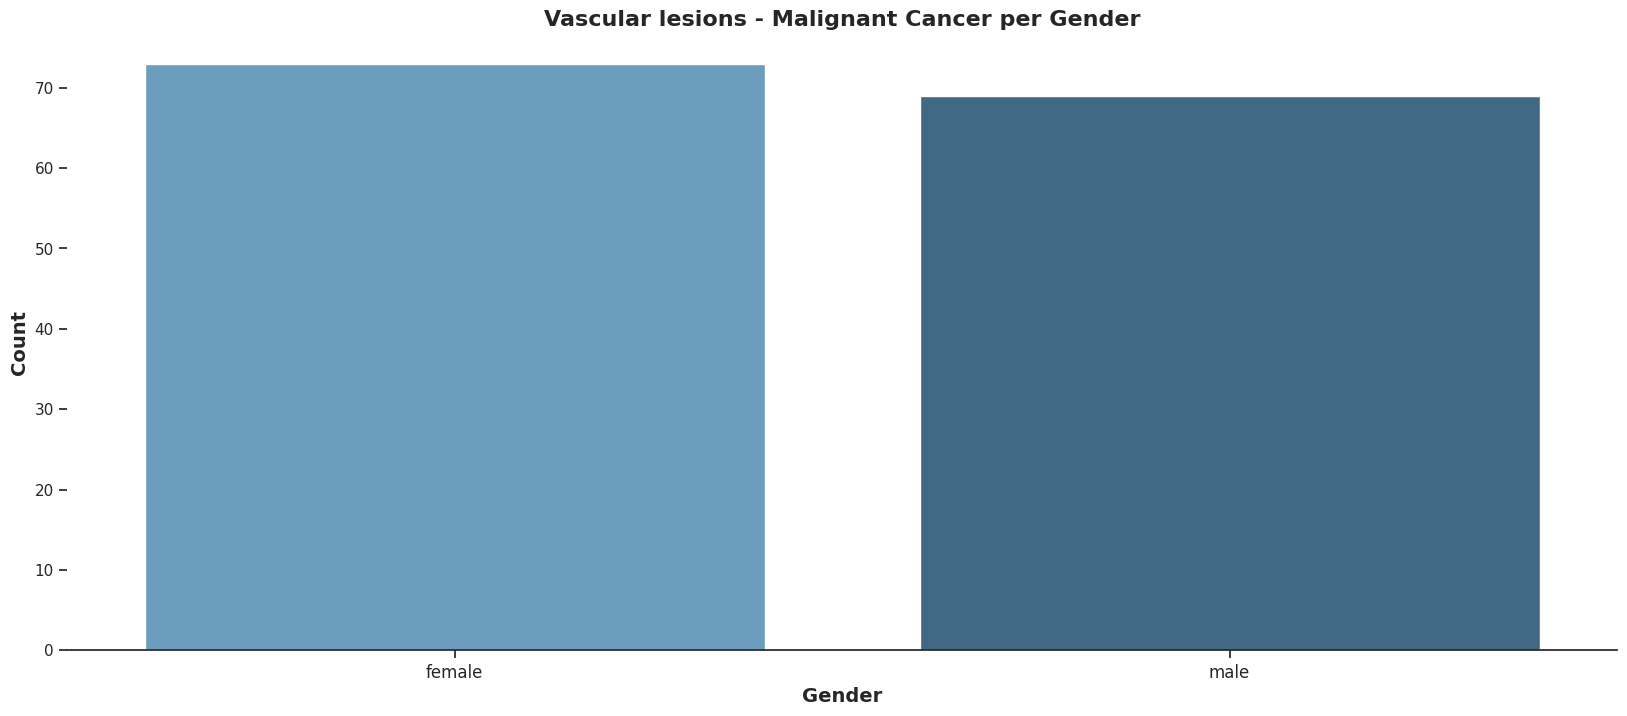

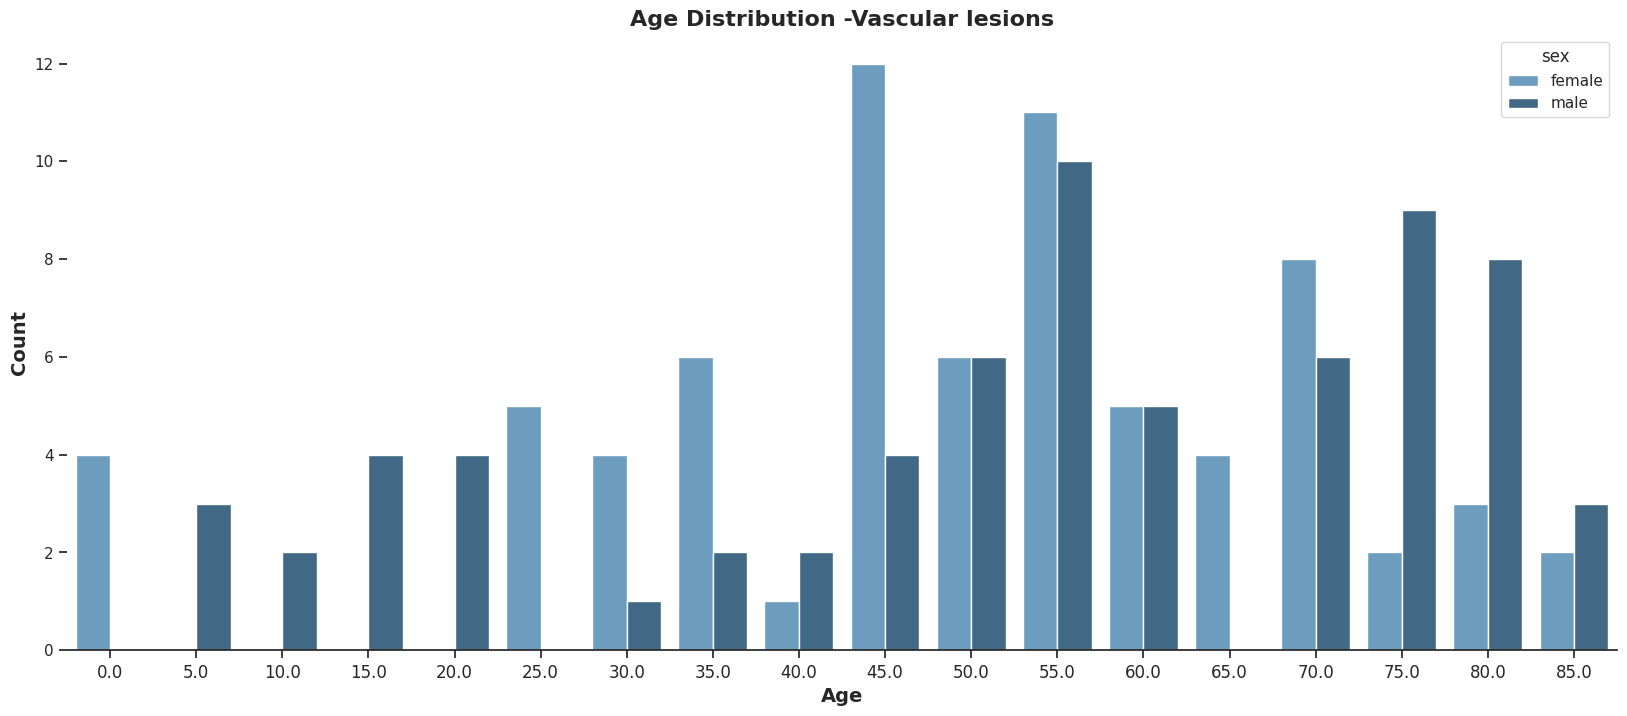

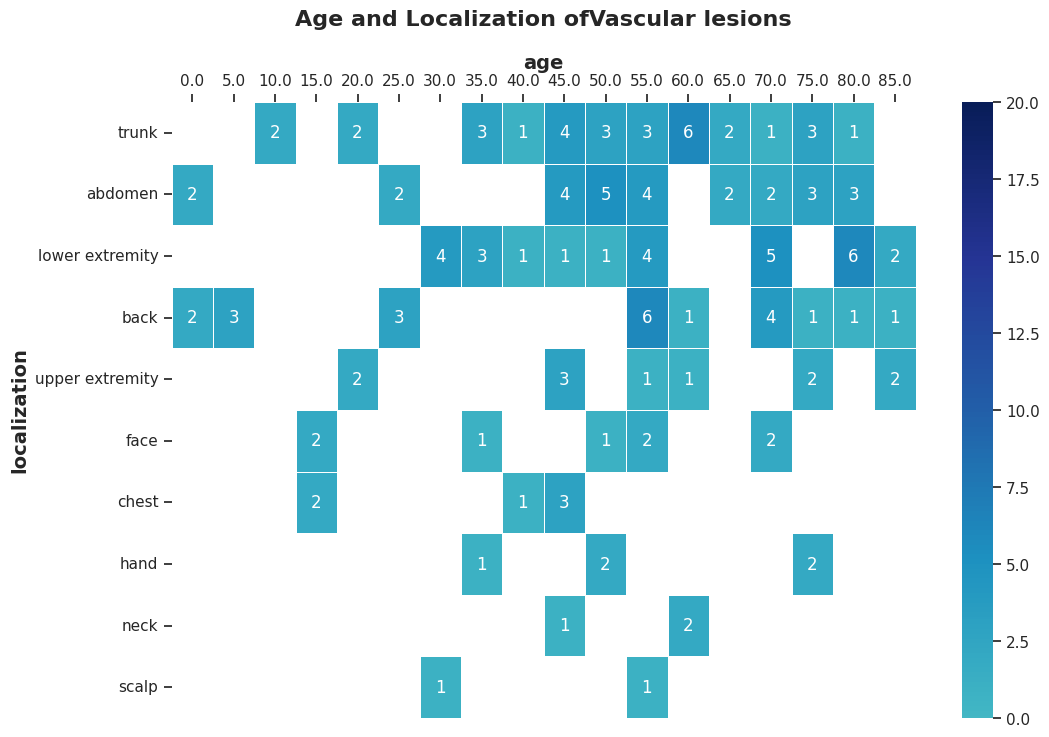

Dermatofibroma


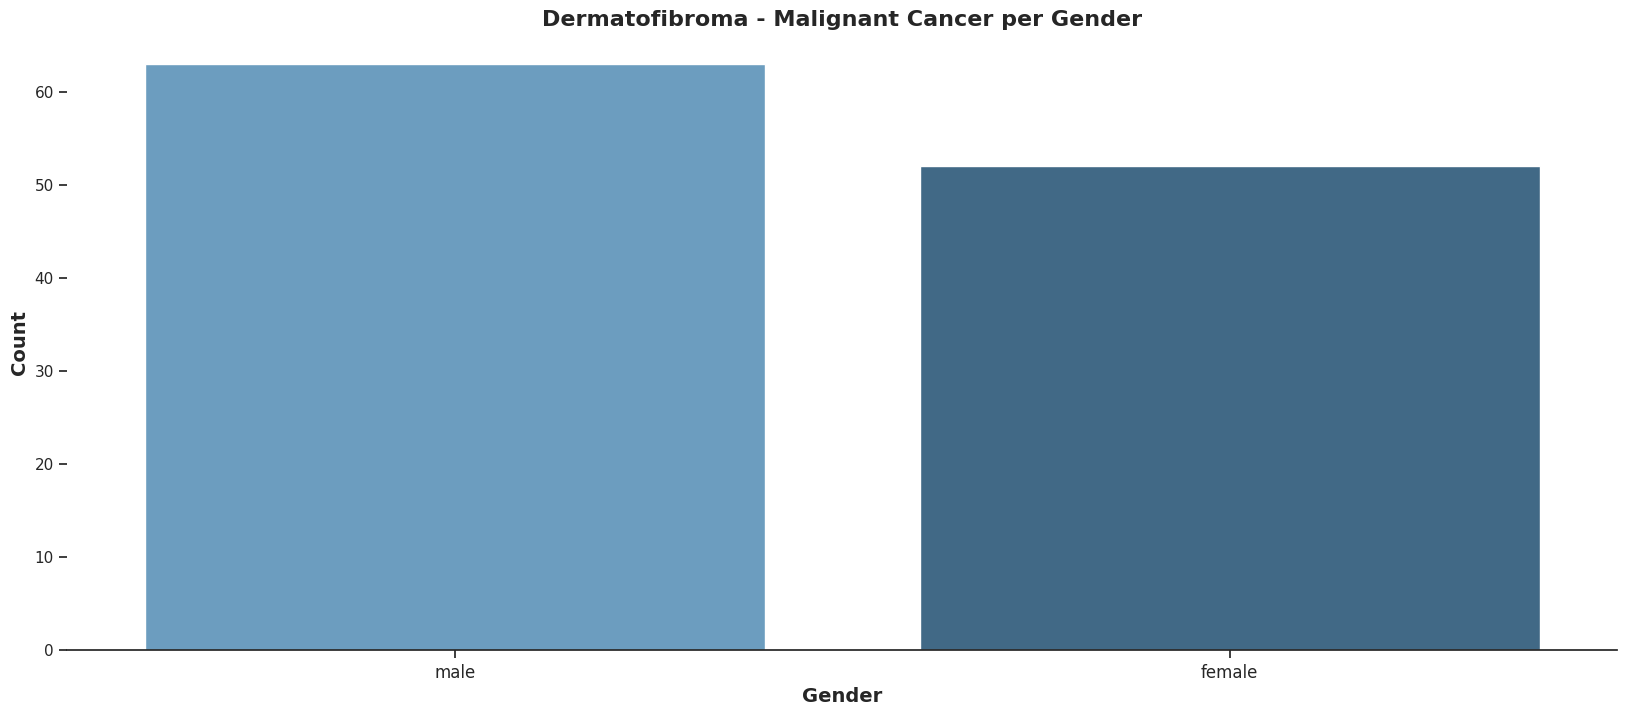

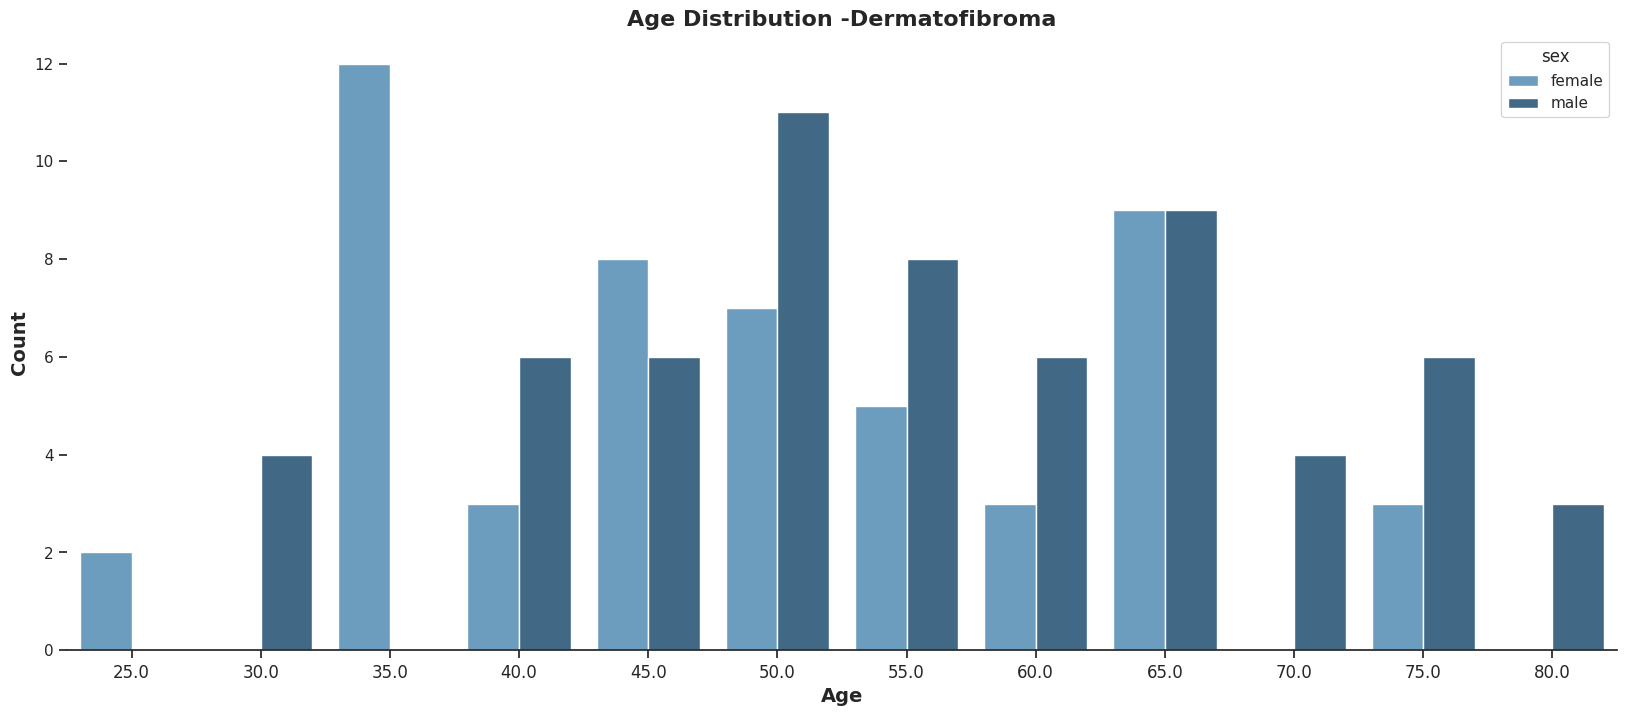

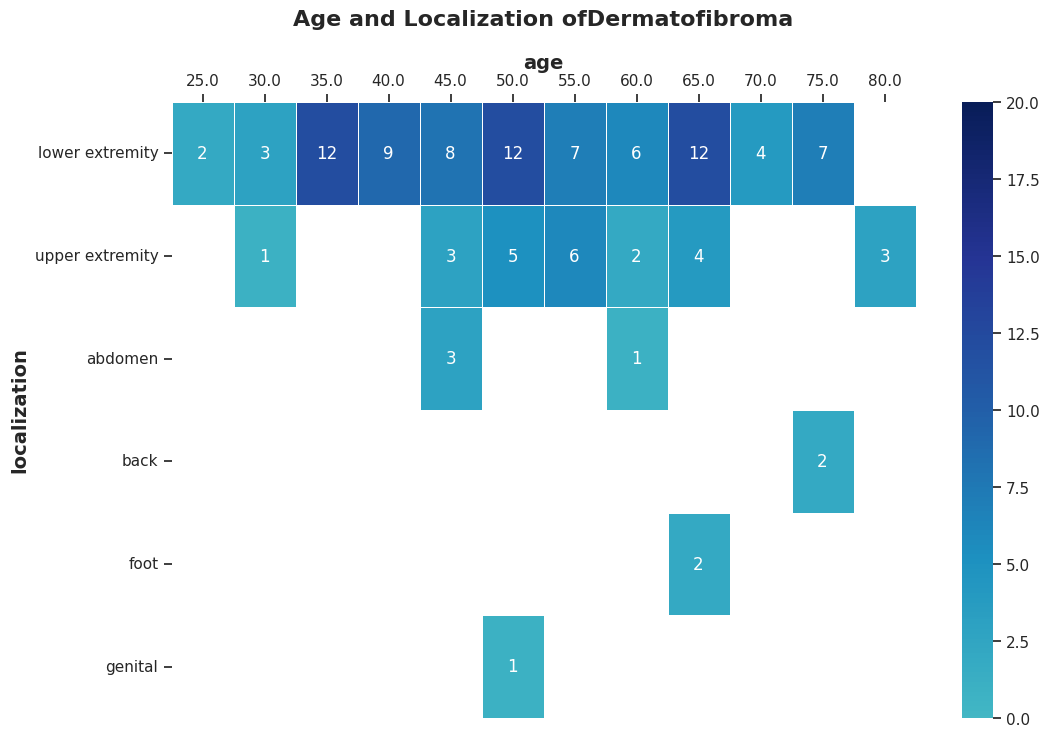

In [21]:
for key in lesion_type_dict:
  ageandlocal(skin_df,lesion_type_dict[key])

In [22]:
from sklearn.utils import resample
dfs_by_label_resampled = {}
n_samples = 800

for label in range(7):
    df_label_resampled = resample(skinDf[skinDf['label'] == label], n_samples=n_samples, replace=True, random_state=42)

    # Append the resampled DataFrame to the dictionary
    dfs_by_label_resampled[label] = df_label_resampled

balanced_df = pd.concat(dfs_by_label_resampled.values())

# Shuffle the rows
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)
balanced_df['label'].value_counts()




label
5    800
2    800
3    800
4    800
1    800
0    800
6    800
Name: count, dtype: int64

In [23]:

from glob import glob
from PIL import Image

imgPath={os.path.splitext(os.path.basename(x))[0]: x
                            for x in glob(os.path.join('/kaggle/input/skin-cancer-mnist-ham10000/','*','*.jpg'))}

size = (64, 64)


balanced_df['image'] = balanced_df['image_id'].map(imgPath.get).map(lambda x: np.asarray(Image.open(x).resize(size)))


In [24]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
sampled_images = balanced_df['image'].sample(6, random_state=42)
size = (64, 64)
sampled_images = [Image.fromarray(img).resize(size) for img in sampled_images]

sampled_images = [np.array(img) for img in sampled_images]

fig = make_subplots(rows=2, cols=3, subplot_titles=("Image 1", "Image 2", "Image 3", "Image 4", "Image 5", "Image 6"))

for i, img in enumerate(sampled_images, start=1):
    fig.add_trace(go.Image(z=img), row=(i-1) // 3 + 1, col=(i-1) % 3 + 1)

fig.update_layout(
    title="Sample Images",
    width=800,
    height=600,
    margin=dict(l=20, r=20, t=60, b=20),
)

fig.show()

In [25]:
from keras.utils import to_categorical
x=np.asarray(balanced_df['image'].to_list())
x=x/255
y=balanced_df['label']
y=to_categorical(y,num_classes=7)
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=42,shuffle=True)



In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',input_shape=(64,64,3)))
model.add(layers.MaxPooling2D())
model.add(BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal'))
model.add(layers.MaxPooling2D())
model.add(layers.BatchNormalization())
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(rate=0.5))
model.add(Dense(32, activation='relu', kernel_initializer='he_normal', ))
model.add(BatchNormalization())

model.add(Dense(units=7, activation='softmax', kernel_initializer='glorot_uniform', name='classifier'))
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train ,
                    y_train ,
                    epochs=50,
                    batch_size=8,
                    validation_data=(x_test , y_test) ,
                    )

Epoch 1/50
560/560 [==============================] - 17s 10ms/step - loss: 2.0273 - accuracy: 0.2225 - val_loss: 1.6704 - val_accuracy: 0.3598
Epoch 2/50
560/560 [==============================] - 4s 7ms/step - loss: 1.7765 - accuracy: 0.2721 - val_loss: 1.4819 - val_accuracy: 0.4179
Epoch 3/50
560/560 [==============================] - 4s 7ms/step - loss: 1.5367 - accuracy: 0.3902 - val_loss: 1.4352 - val_accuracy: 0.4179
Epoch 4/50
560/560 [==============================] - 5s 9ms/step - loss: 1.4534 - accuracy: 0.4315 - val_loss: 1.2915 - val_accuracy: 0.4866
Epoch 5/50
560/560 [==============================] - 4s 7ms/step - loss: 1.3530 - accuracy: 0.4779 - val_loss: 1.1987 - val_accuracy: 0.5196
Epoch 6/50
560/560 [==============================] - 4s 8ms/step - loss: 1.2963 - accuracy: 0.5145 - val_loss: 1.4035 - val_accuracy: 0.4313
Epoch 7/50
560/560 [==============================] - 5s 8ms/step - loss: 1.2558 - accuracy: 0.5348 - val_loss: 1.0817 - val_accuracy: 0.5920
Epoc

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)

print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

In [ ]:
import matplotlib.pyplot as plt

tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = [i+1 for i in range(len(tr_acc))]

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, tr_loss, 'r', label='Train Loss')
plt.plot(epochs, val_loss, 'g', label='Valid Loss')
plt.title('Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
plt.plot(epochs, val_acc, 'g', label='Valid Accuracy')
plt.title('Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/model_save_final.keras')